# Sampling MNIST images

In [1]:
using MLDatasets
using OneHotArrays
preprocess((x, y)) = reshape(x, 28, 28, 1, :), onehotbatch(y, 0:9)
xtrain, ytrain = preprocess(MLDatasets.MNIST(:train)[1:50]);

In [2]:
using PythonPlot

function plot_images(x, y, suptitle)
    fig, axes = subplots(5, 10, sharex = true, sharey = true, dpi = 120)
    for (i, idx) in enumerate(CartesianIndices((5, 10)))
        ax = axes[idx[1]-1,idx[2]-1]
        ax.imshow(x[:,:,1,i]')
        ax.set(title = onecold(y[:,i]) - 1)
        ax.get_xaxis().set_visible(false)
        ax.get_yaxis().set_visible(false)
    end
    fig.suptitle(suptitle)
    fig.tight_layout()
    return fig
end

plot_images (generic function with 1 method)

## Forward diffusion

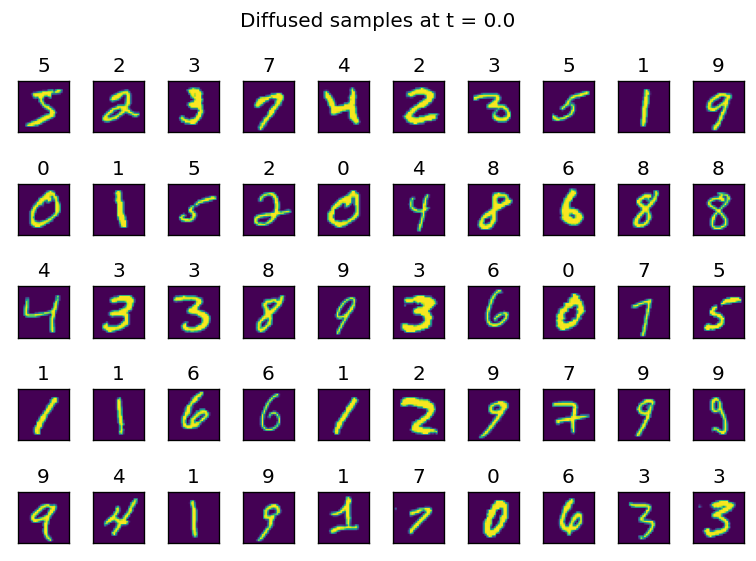

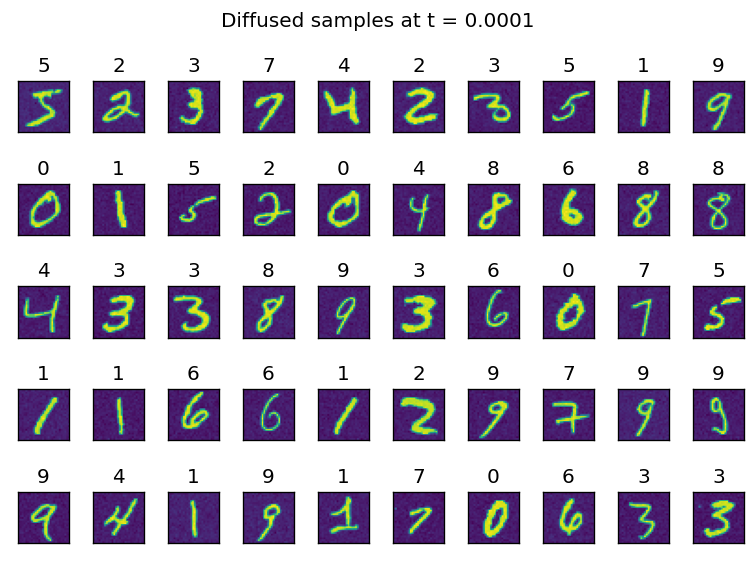

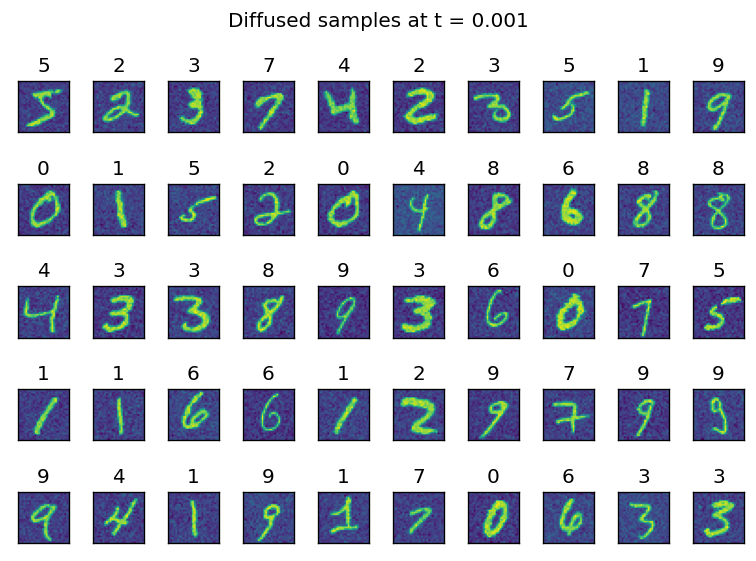

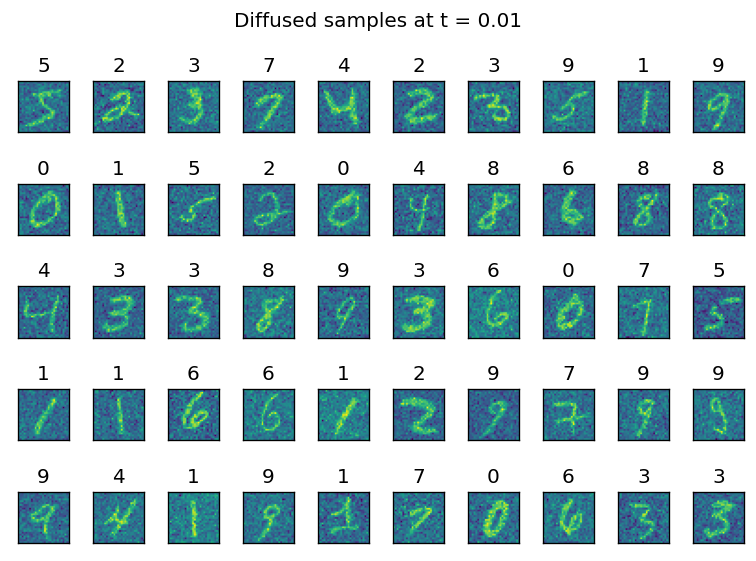

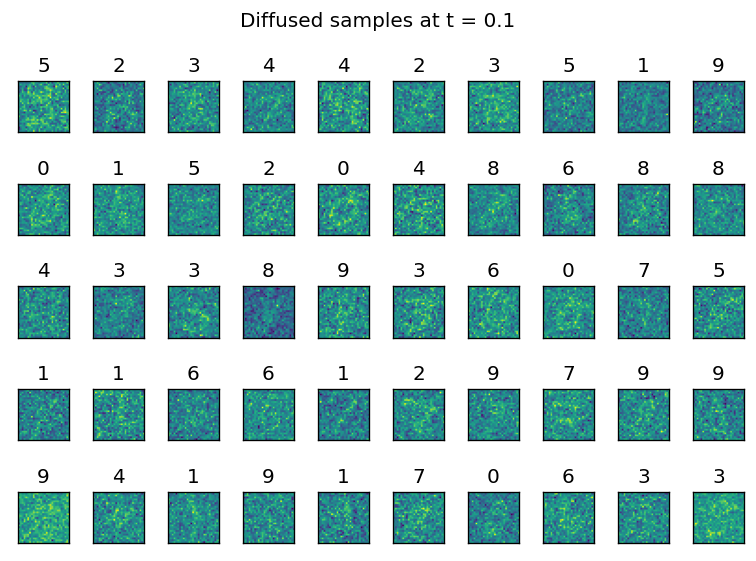

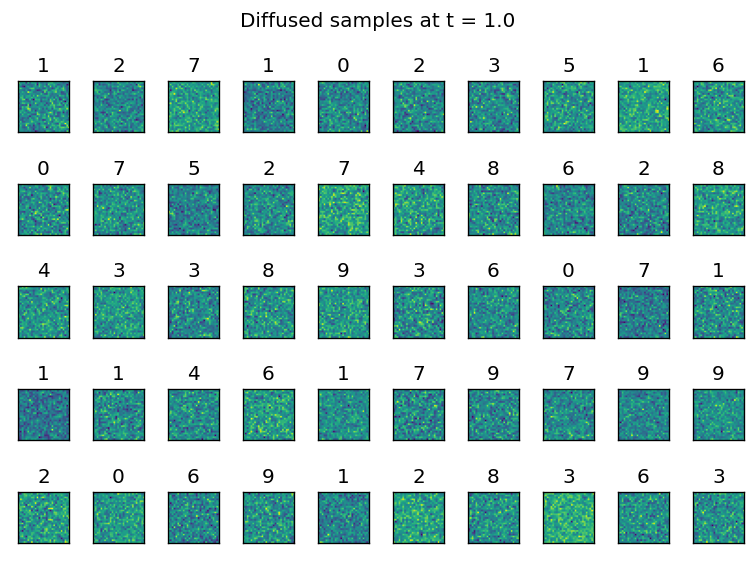

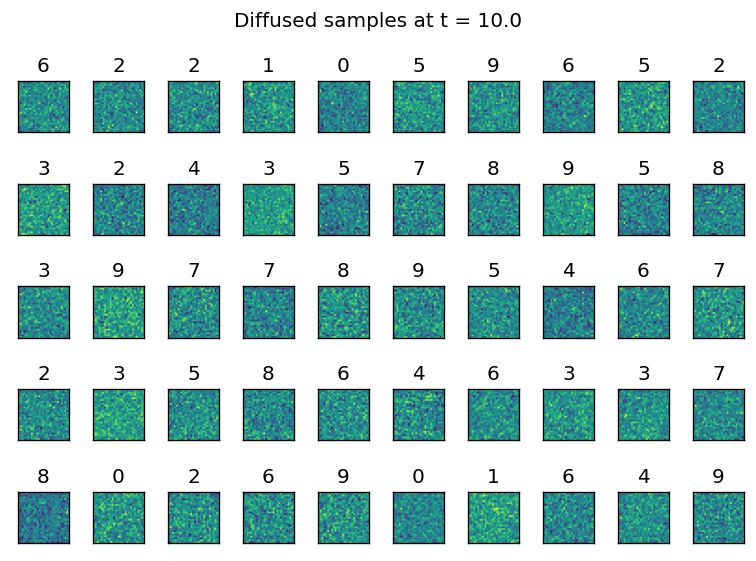

In [3]:
using Diffusions
using Random

rng = Xoshiro(1234)
θ = 4.0f0  # reversion
σ = √(2θ)  # volatility
p = ones(Float32, 10) ./ 10  # equilibrium distribution
diffusion = (OrnsteinUhlenbeckDiffusion(0, σ, θ), IndependentDiscreteDiffusion(0.5f0, p))
for t in Float32[0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
    x, y = sampleforward(rng, diffusion, t, (xtrain, ytrain))
    plot_images(x, y, "Diffused samples at t = $t")
end

In [4]:
timesteps = exp.(range(log(1f-4), log(1f+1), length = 501))

501-element Vector{Float32}:
  9.999998f-5
  0.00010232925
  0.00010471287
  0.00010715191
  0.000109647764
  0.00011220186
  0.00011481533
  0.00011748969
  0.00012022645
  0.00012302684
  0.00012589258
  0.00012882495
  0.00013182563
  ⋮
  7.7624707
  7.943283
  8.128305
  8.317638
  8.51138
  8.709635
  8.91251
  9.120108
  9.332543
  9.549926
  9.772373
 10.0

In [5]:
using BSON: @load
include("model.jl")
@load "mnist-500.bson" unet

## Backward denoising

In [6]:
# See the following paper for self-conditioning:
# Chen, Ting, Ruixiang Zhang, and Geoffrey Hinton. "Analog bits: Generating
# discrete data using diffusion models with self-conditioning." arXiv preprint
# arXiv:2208.04202 (2022).
function selfconditioned_guess(x)
    x_0 = zero(x)
    function guess((x_t, y_t), t)
        x̂, ŷ = unet(cat(x_t, x_0, dims = 3), y_t, fill(t, size(y_t, 2)))
        #ŷ[8,:] .+= 100  # encourage to generate images of a specific class
        x_0 = sigmoid.(x̂)
        return x_0, onehotbatch(randcat(softmax(ŷ, dims = 1)) .- 1, 0:9)
    end
end

rng = Xoshiro(1234)
x = randn(rng, Float32, (28, 28, 1, 50))
y = onehotbatch(rand(rng, 0:9, 50), 0:9)
xy_0 = samplebackward(rng, selfconditioned_guess(x), diffusion, timesteps, (x, y));

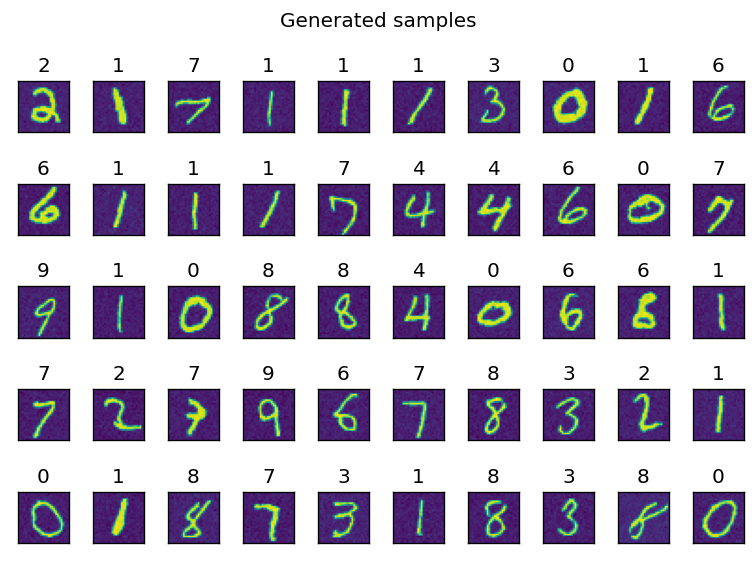

In [7]:
plot_images(sigmoid.(xy_0[1]), xy_0[2], "Generated samples");